# Auto MPG Prediction 

Dataset can be found at the UCI Machine Learning Repository: [Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition.

In [13]:
%matplotlib notebook

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Modify the style of the plots 
sns.set_context('notebook')
sns.set_style('whitegrid')

## Data Loading 

Download the `auto.data` file from the UCI ML Repository and store it in a folder called `data` that is in the same directory as this notebook.

The data loader creates a Pandas DataFrame with named columns and adds a feature for the make of the vehicle by parsing the `car name` field. It also replaces `"?"` with `np.nan` for fields with missing values. 

In [14]:
feature_names = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model year",
    "origin",
    "car name",
]

def load_data(path="data/auto.data"):
    data = pd.read_csv('data/auto.data', delimiter='\s+', header=None)
    data.columns = feature_names
    
    # Get the make of the vehicle as the first word in the name 
    data['make'] = data['car name'].apply(lambda s: s.split()[0])
    
    # Replace '?' with np.nan 
    data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')
    
    return data 

In [15]:
data = load_data() 
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
make             object
dtype: object

### Features and Target 

Divide the data into features and target splits. 

In [39]:
target = "mpg"
features = [c for c in data.columns if c not in {'car name', 'mpg'}]

X = data[features]
y = data[target]

In [40]:
X.describe()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


One-hot encode the make of the vehicle and impute missing horsepower values with the mean. 

In [41]:
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder

make_encoder = LabelEncoder()
X['make'] = make_encoder.fit_transform(X['make'])

imputer = Imputer()
X = imputer.fit_transform(X)

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Make classification target for multiple model examples (not just regression). 

Use a histogram to determine where best to divide the target into high/medium/low MPG classes:

<IPython.core.display.Javascript object>


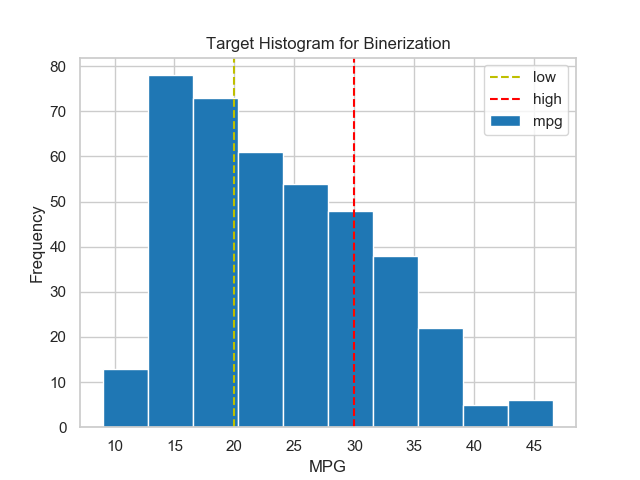

In [27]:
ax = y.plot(kind='hist')
ax.set_title("Target Histogram for Binerization")
ax.set_xlabel("MPG")

ax.axvline(20, c='y', ls='--', label="low")
ax.axvline(30, c='r', ls='--', label="high")
ax.legend()

In [28]:
def make_classifier(yi):
    if yi > 30:
        return "high"
    if yi < 20:
        return "low"
    return "medium"
    
yc = pd.Series([make_classifier(yi) for yi in y], index=y.index)

In [60]:
label_encoder = LabelEncoder()
yc = label_encoder.fit_transform(yc)

## Feature Analysis

In [31]:
from yellowbrick.features import RadViz, ParallelCoordinates 

<IPython.core.display.Javascript object>


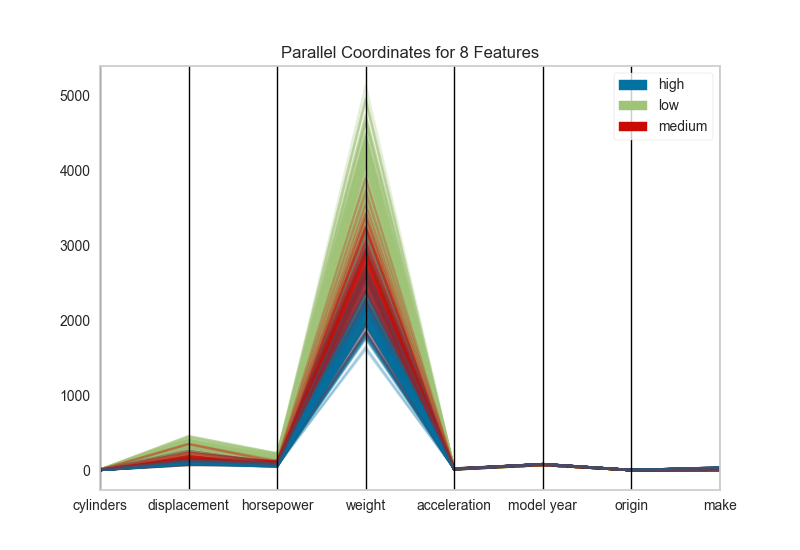

In [65]:
oz = ParallelCoordinates(classes=label_encoder.classes_, features=features)
oz.fit(X, yc)
oz.poof()

<IPython.core.display.Javascript object>


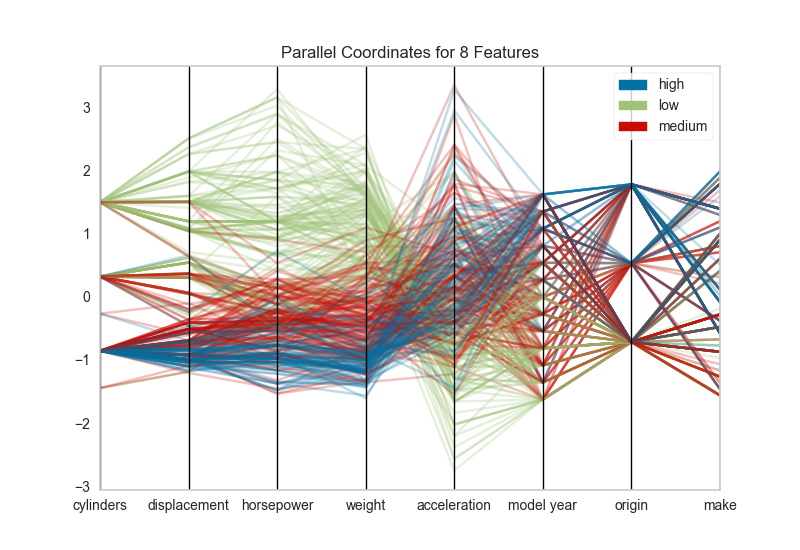

In [64]:
oz = ParallelCoordinates(normalize='standard', classes=label_encoder.classes_, features=features)
oz.fit(X, yc)
oz.poof()

<IPython.core.display.Javascript object>


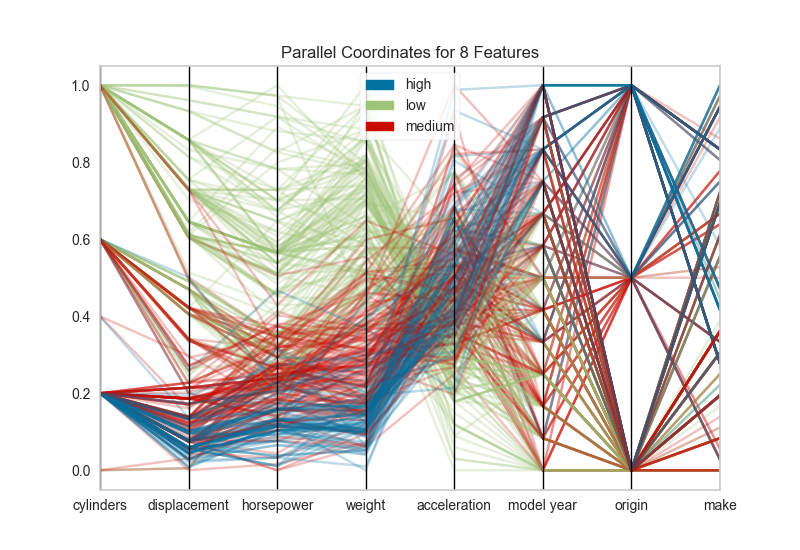

In [63]:
oz = ParallelCoordinates(normalize='minmax', classes=label_encoder.classes_, features=features)
oz.fit(X, yc)
oz.poof()

<IPython.core.display.Javascript object>


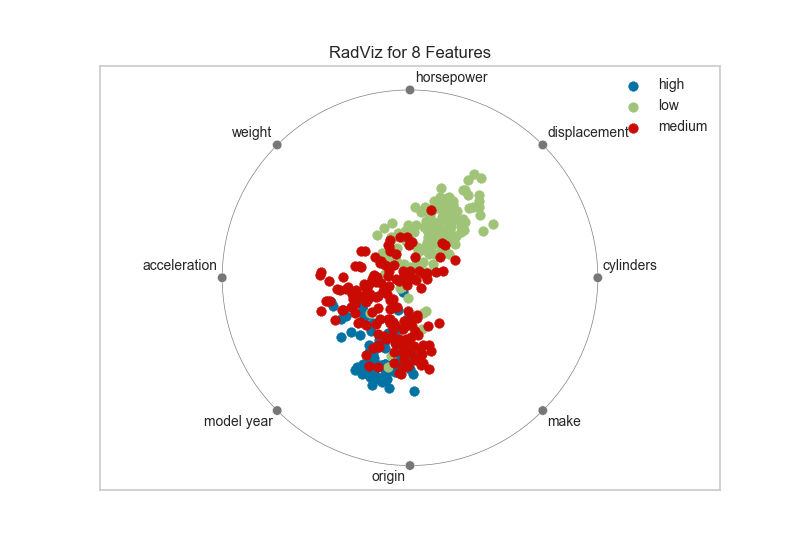

In [62]:
oz = RadViz(classes=label_encoder.classes_, features=features)
oz.fit(X, yc)
oz.poof()

<IPython.core.display.Javascript object>


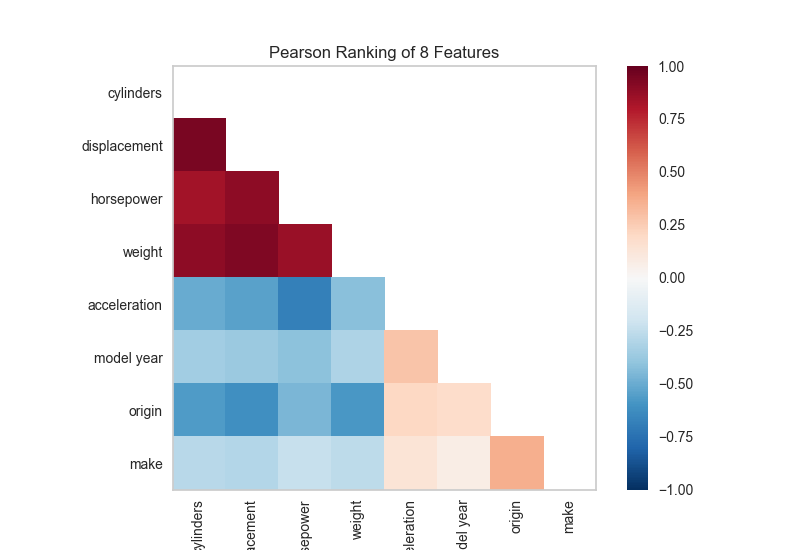

In [69]:
from yellowbrick.features import Rank2D

oz = Rank2D(features=features)
oz.fit_transform(X, yc)
oz.poof()

<IPython.core.display.Javascript object>


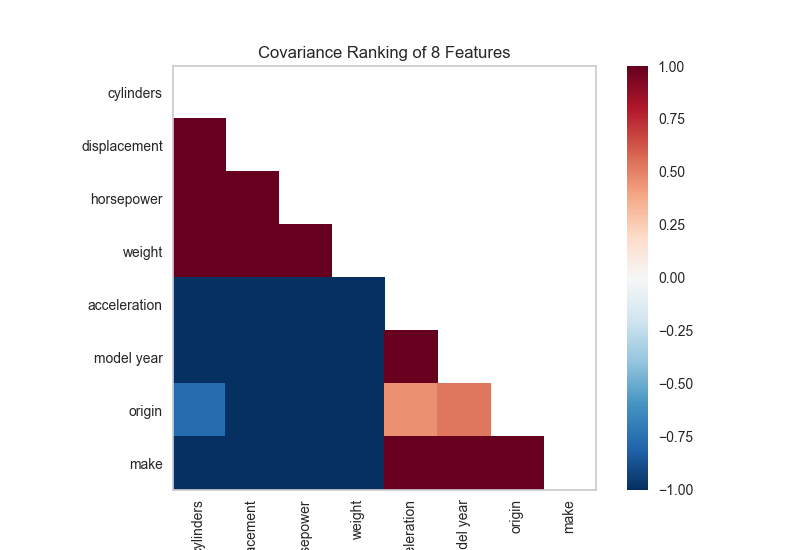

In [72]:
oz = Rank2D(features=features, algorithm='covariance')
oz.fit_transform(X, yc)
oz.poof()

<IPython.core.display.Javascript object>


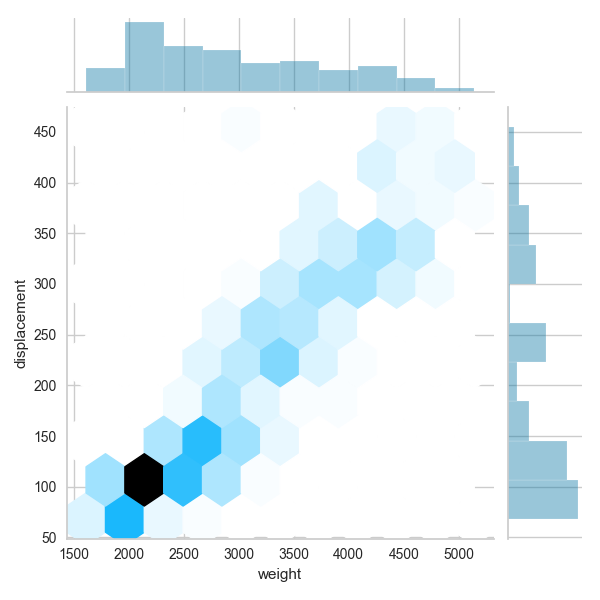

In [73]:
g = sns.jointplot(x='weight', y='displacement', kind='hex', data=data)

In [82]:
from sklearn.model_selection import train_test_split as tts

from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix

In [83]:
X_train, X_test, y_train, y_test = tts(X, yc, test_size=0.2)

<IPython.core.display.Javascript object>


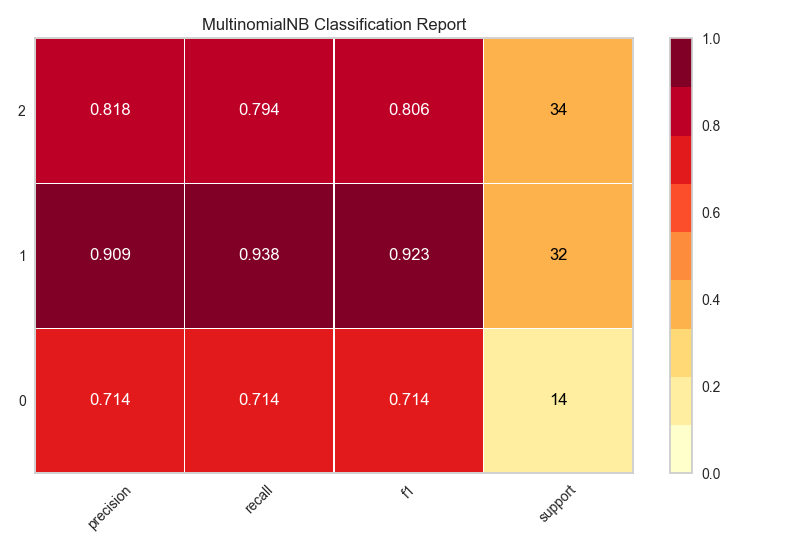

In [84]:
model = MultinomialNB()

oz = ClassificationReport(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

<IPython.core.display.Javascript object>


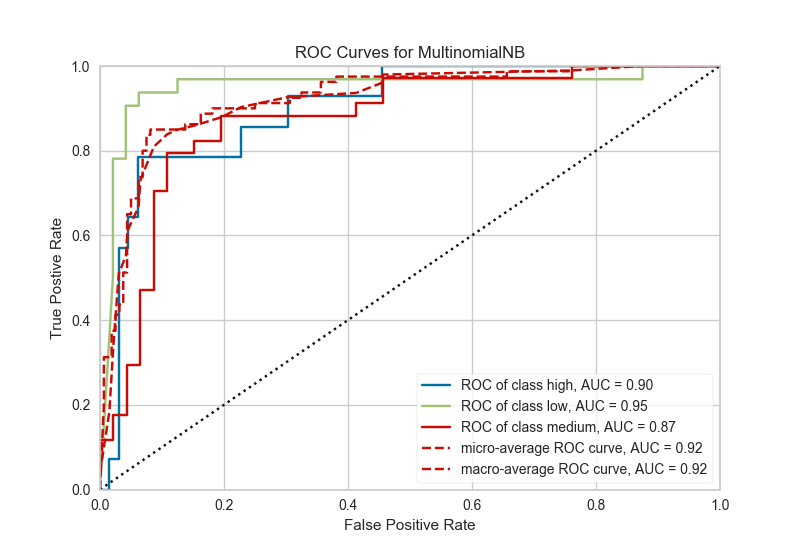

In [102]:
oz = ROCAUC(model, support=True, classes=label_encoder.classes_)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

<IPython.core.display.Javascript object>


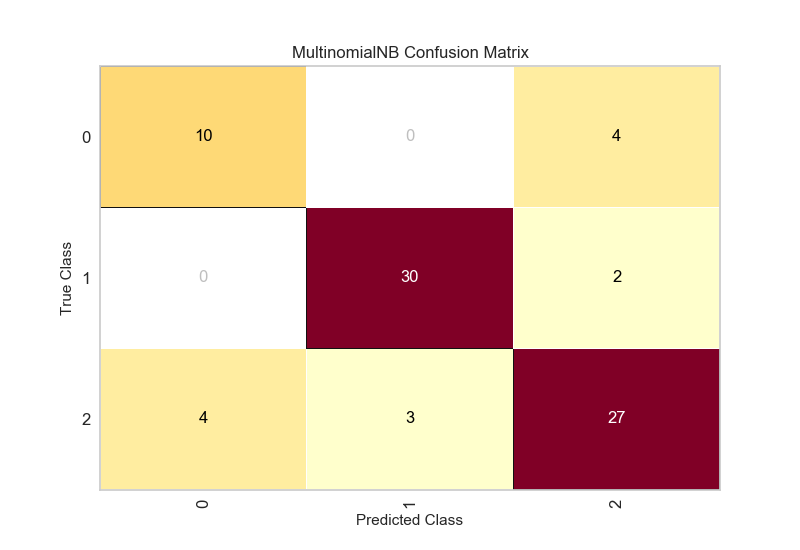

In [106]:
oz = ConfusionMatrix(model, support=True)
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()

In [94]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>


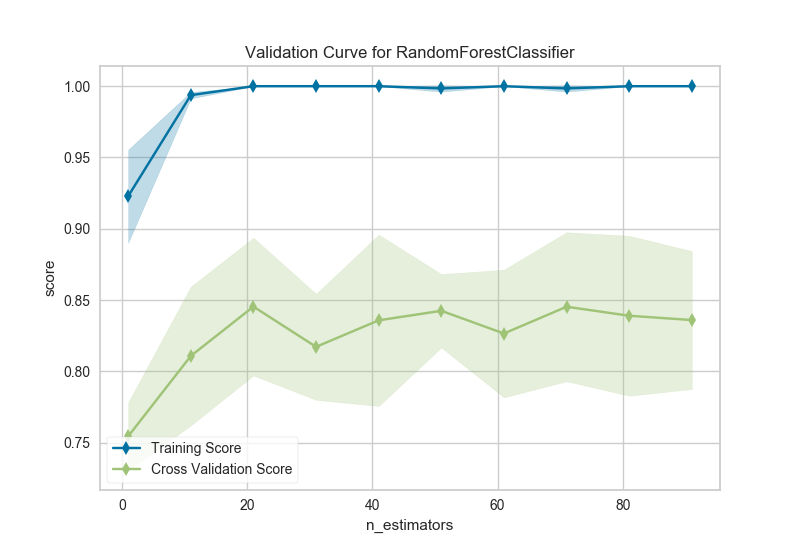

In [101]:
from yellowbrick.model_selection import ValidationCurve

oz = ValidationCurve(RandomForestClassifier(), param_name='n_estimators', param_range=np.arange(1, 100, 10))
oz.fit(X_train, y_train)
oz.poof()